# Federated learning: deep learning for vertically partitioned data 

In this notebook, we provide a simple example of how to perform a **vertical** federated learning experiment with the help of the Sherpa.ai Federated Learning framework. 
As opposed to the horizontal federated learning paradigm, in a vertical federated learning setting (see e.g. [Federated Machine Learning: Concept and Applications](https://arxiv.org/abs/1902.04885)) the different nodes possess the same samples, but different features. 
A practical example being that of a local on-line shop and an insurance company: both entities might have matching customers (samples), but the information (features) each entity possesses about the customers is of different nature. 
We are going to use a synthetic dataset and a neural network model.


## The data
We use `sklearn` module for generating synthetic databases. 
Moreover, in order to simulate a vertically partitioned training data, we randomly split the features of the created dataset among the clients:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from shfl.private.reproducibility import Reproducibility

# Comment to turn off reproducibility:
Reproducibility(568)

# Create dataset
n_features = 20
n_classes = 2
n_samples = 15000

data, labels = make_classification(
    n_samples=n_samples, n_features=n_features, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, flip_y=0.1, class_sep=0.4, random_state=123)

**Vertical split of the dataset.** In the vertical FL setting, the database is split along the columns (i.e., vertically) among the nodes. 
We can use a method provided by the Sherpa FL Framework to randomly split a dataset vertically into the desired number of parts: 

In [2]:
from shfl.data_base.data_base import vertical_split

# Create a vertically split dataset: split the features among clients
M = 2  # number of clients
train_data, train_labels, test_data, test_labels = \
    vertical_split(data=data, labels=labels)

for item in train_data:
    print("Client train data shape: " + str(item.shape))

Client train data shape: (12000, 11)
Client train data shape: (12000, 9)


**Wrap into FederatedData.** At this point, we assign the data to a federated network of clients. 
Since the clients actually don't possess the labels (only the server does), we assign the client's labels to `None`. 
And since we already performed the split of data for each client, we just use `PlainDataDistribution` to create the wrapper for the federated data (this class converts the data "as is" into a `FederatedData` object):

In [3]:
# Make federated data: 
from shfl.data_base.data_base import LabeledDatabase
from shfl.data_distribution.data_distribution_plain import PlainDataDistribution

clients_labels = [None] * len(train_data) 
data_base = LabeledDatabase(data=train_data, 
                            labels=clients_labels, 
                            train_percentage=1., 
                            shuffle=False) 
data_base.load_data()
federated_data, _, _ = PlainDataDistribution(database=data_base).get_federated_data()
print(federated_data)

**Federated transformation.** In case we need to perform a data transformation on all the clients of the federated data, this is easily achieved by the framework's method: 

In [4]:
# Federated data operation: need to transform to tensors
import torch

from shfl.private import FederatedTransformation

class FromNumpyFloat(FederatedTransformation):
    
    def apply(self, labeled_data):
        if labeled_data.data is not None:
            labeled_data.data = torch.from_numpy(labeled_data.data).float()
        
federated_data.apply_data_transformation(FromNumpyFloat());

In order to visually check everything went fine with the data assignment, we can configure data access to node (otherwise protected by default):

In [5]:
# Check federated data:
from shfl.private.data import UnprotectedAccess

federated_data.configure_data_access(UnprotectedAccess());
federated_data[0].query()
federated_data[0].query().data.shape
#federated_data[0].query().label

torch.Size([12000, 11])

## The model:

**Horizontal Vs Vertical Federated Learning.** Both in the  Federated Government is interpreted as follows: 
 - The Federated Government is intended as a *Coordinator*: it defines and schedules the federated computations, but does not have any other function (no data, no model). It is what a user can customize for the specific case problem.
 - The Federated Data is composed by nodes that can have multiple functions: train, store data, aggregate, make auxiliary computations, predictions etc.
 - In particular, the Server is itself a *node* that can interact with the Federated Data: it might aggregate, but might also contain data and train on them

In Horizontal FL (see e.g. the [basic concepts notebook](./federated_learning_basic_concepts.ipynb)), all nodes have typically the same model, and the server node has also the aggregation function in its model as an attribute but do not train and does not possess any data.
Instead in a Vertical FL architecture, the client nodes might have a *different model* with respect each other and with respect the server node.
The latter in turn can aggregate, train and might possess its own data (i.e. the labels in this case).

Note that the distinction between client and server is *only virtual* and not necessarily physical, since a single node might be both client and server, allowing multiple roles for the same physical node.   

**Define the server node.** We said that in the Vertical FL, each node, including the server, is allowed to possess a different model and different methods for interacting with the clients.
We here define the server model with specific functions needed for the present Vertical FL architecture.
The server is assigned a linear model, along with the data to train on (only labels, in this specific example): 

In [6]:
from sklearn.metrics import roc_auc_score
from shfl.model import DeepLearningModelPyTorch


class VerticalNeuralNetServer(DeepLearningModelPyTorch): 
    
    def __init__(self, model, loss, optimizer, batch_size=32, 
                 epochs=1, metrics=None, device="cpu"):
        
        super().__init__(model, loss, optimizer, batch_size=batch_size, 
                       epochs=epochs, metrics=metrics, device=device)
        
        self._epsilon = None
        self._sensitivity = None
        self._embeddings_indices = None
        self._grad_embeddings = None

    def train(self, data, labels, **kwargs):
        """
        Implementation of abstract method of class
        [TrainableModel](../Model/#trainablemodel-class).

        # Arguments
            data: clients' data
            labels: Target classes, array-like of shape (n_samples,)
            embeddings: clients' embeddings
        """

        embeddings = torch.stack(kwargs.get("embeddings"), dim=0).sum(dim=0)
        embeddings = torch.autograd.Variable(embeddings, requires_grad=True)
        self._embeddings_indices = kwargs.get("embeddings_indices")
        labels = torch.from_numpy(labels)[self._embeddings_indices].reshape(-1).float()
        
        self._optimizer.zero_grad()
        prediction = self._model(embeddings).reshape(-1)
        loss = self._loss(prediction, labels)
        loss.backward()
        self._optimizer.step()
        
        self._grad_embeddings = embeddings.grad
        
    def evaluate(self, data, labels):
        """
        Evaluation of global model.

        # Arguments
            data: predicted labels
            labels: true labels
        """

        auc = roc_auc_score(labels, data)

        return auc

    def get_meta_params(self):
        """ Returns computed embeddings' gradients. """

        return self._grad_embeddings, self._embeddings_indices

    def compute_loss(self, embeddings, embeddings_indices, labels):
        """ Compute loss. """
        
        labels = torch.from_numpy(labels)[embeddings_indices].reshape(-1).float()
        embeddings = torch.stack(embeddings, dim=0).sum(dim=0)
        prediction = self._model(embeddings).reshape(-1)
        loss = self._loss(prediction, labels)

        return loss.detach().numpy()

    def performance(self, data, labels):
        return self.evaluate(data, labels)

In [7]:
# from shfl.model.vertical_deep_learning_model import VerticalLogLinearServer
from shfl.private.federated_operation import VerticalServerDataNode
from shfl.private.data import LabeledData

n_embeddings = 2

model_server = torch.nn.Sequential(
    torch.nn.Linear(n_embeddings, 1, bias=True),
    torch.nn.Sigmoid())

# model_server[0].weight = torch.nn.Parameter(torch.tensor([[1.]]))
# model_server[0].bias = torch.nn.Parameter(torch.normal(mean=torch.tensor([0.]), std=torch.tensor([0.01])))
# model_server[0].bias = torch.nn.Parameter(torch.tensor([0.1]))
# model_server[0].weight.requires_grad = False


loss_server = torch.nn.BCELoss(reduction="mean")
optimizer_server = torch.optim.SGD(params=model_server.parameters(), lr=0.001)


# Create the server node: 
server_node = VerticalServerDataNode(
    federated_data=federated_data, 
    model=VerticalNeuralNetServer(model_server, loss_server, optimizer_server), 
    aggregator=None,
    data=LabeledData(data=None, label=train_labels))

In [8]:
for layer in model_server.parameters():
    print(layer)

Parameter containing:
tensor([[0.3515, 0.3290]], requires_grad=True)
Parameter containing:
tensor([0.2528], requires_grad=True)


**Define specific data access needed for the Vertical FL round.** The specific Vertical FL architecture requires the computation of the Loss and the exchange of convergence parameters. 
Namely, the clients send the computed embeddings to the server, and the server sends the computed gradients to update the clients. 
Therefore, we define ad-hoc access definitions for these methods, and we assign them to server and clients: 

In [9]:
from shfl.private.data import DataAccessDefinition

class ComputeLoss(DataAccessDefinition):
    def apply(self, data, **kwargs): 
        server_model = kwargs.get("server_model")
        embeddings = kwargs.get("embeddings")
        embeddings_indices = kwargs.get("embeddings_indices")
        
        loss = server_model.compute_loss(
            embeddings, embeddings_indices, data.label)
        
        print("Collaborative model train loss: " + str(loss))
        
        return loss
    
    
class QueryMetaParameters(DataAccessDefinition):
    def apply(self, model, **kwargs):
        """Returns embeddings (or their gradients) as computed by the local model."""
        return model.get_meta_params(**kwargs)

    
# Configure data access to nodes and server
federated_data.configure_model_access(QueryMetaParameters())
server_node.configure_model_access(QueryMetaParameters())
server_node.configure_data_access(ComputeLoss())   

print(federated_data[1]._model_access_policy)
print(server_node._model_access_policy)
print(server_node._private_data_access_policies)

{'140417905377968': <__main__.ComputeLoss object at 0x7fb593d180f0>}


## Run the federated learning experiment

We are almost done: we only need to specify which specific model to use for each client node, and the server node. 
Namely, the clients will run a neural network model, but of course they will have different input size since they possess different number of features. 
We first don't use hidden layers for the clients model, resulting in a *linear* model (`layer_dims=None` parameter):

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from shfl.model import DeepLearningModelPyTorch


class TensorDatasetIndex(TensorDataset):
    '''Additionally returns indices of samples'''
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors), index
    

class VerticalNeuralNetClient(DeepLearningModelPyTorch): 
    
    def __init__(self, model, loss, optimizer, batch_size=32, 
                 epochs=1, metrics=None, device="cpu"):
        
        super().__init__(model, loss, optimizer, batch_size=batch_size, 
                       epochs=epochs, metrics=metrics, device=device)
        
        self._embeddings = None
        self._embeddings_indices = None
        self._batch_counter = 0
        self._epoch_counter = 0
        self._data_loader = None
    
    def train(self, data, labels, **kwargs):
        """
        Implementation of abstract method of class
        [TrainableModel](../Model/#trainablemodel-class).
        The training on the client node is comprised of two stages:
        1) Feedforward, where the embeddings are computed using the local model
        2) Backpropagation when received embeddings' gradients

        # Arguments
            data: Data, array-like of shape (n_samples, n_features)
            labels: Target classes, array-like of shape (n_samples,)
            kwargs: dictionary containing the embeddings gradients (used only
                in the backpropagation stage of the training)
        """
       
        if "meta_params" not in kwargs:

            # Feedforward:
            
            if self._data_loader is None:
                self._check_data(data)
                data = TensorDatasetIndex(data)
                data_loader = DataLoader(data, self._batch_size)
                self._data_loader = [item for item in data_loader]
            
            data_batch, self._embeddings_indices = \
                self._data_loader[self._batch_counter]
                    
            self._embeddings = self._model(data_batch[0])

        else:

            # Backpropagate the gradients w.r.t. embeddings:
            grad_embeddings, embeddings_indices = kwargs.get("meta_params")
           # self._check_embedding_indices(embeddings_indices)
            
            grad_embeddings = grad_embeddings.reshape(self._embeddings.shape)
            
            self._optimizer.zero_grad()
            self._embeddings.backward(gradient=grad_embeddings)
            self._optimizer.step()
        
            self._batch_counter += 1 
            if self._batch_counter == len(self._data_loader):
                self._batch_counter = 0
                self._epoch_counter += 1
                
    def get_meta_params(self):
        """ Return computed embeddings. """
        
        return [self._embeddings, 
                self._embeddings_indices]
    
    def _check_embedding_indices(self, embeddings_indices):
        """
        Method that checks whether the indices of gradients  
        correspond to the indices of the embeddings.
        """
        embeddings_indices = torch.from_numpy(embeddings_indices)
        if not self._embeddings_indices.equal(embeddings_indices):
            raise AssertionError("Current batch indices " + str(self._embeddings_indices) + 
                                 " do not match the output gradients indices " + str(embeddings_indices) )

In [11]:
#from shfl.model.vertical_deep_learning_model import VerticalNeuralNetClient

model0 = nn.Sequential(
    nn.Linear(train_data[0].shape[1], n_embeddings, bias=True),
)

model1 = nn.Sequential(
    nn.Linear(train_data[1].shape[1], n_embeddings, bias=True),
)

optimizer0 = torch.optim.SGD(params=model0.parameters(), lr=0.001)
optimizer1 = torch.optim.SGD(params=model1.parameters(), lr=0.001)

batch_size = 32
model_nodes = [VerticalNeuralNetClient(model=model0, loss=None, optimizer=optimizer0, batch_size=batch_size),
               VerticalNeuralNetClient(model=model1, loss=None, optimizer=optimizer1, batch_size=batch_size)]

In [12]:
for layer in model0.parameters():
    print(layer)
    
for layer in model1.parameters():
    print(layer)

Parameter containing:
tensor([[ 0.0460,  0.2073,  0.1491, -0.2929, -0.1053, -0.2582,  0.0743, -0.0865,
         -0.1360,  0.1849, -0.2111],
        [-0.1739, -0.2327,  0.0872,  0.1774,  0.1059, -0.0926, -0.1195, -0.1487,
          0.0066, -0.0082,  0.0316]], requires_grad=True)
Parameter containing:
tensor([ 0.1268, -0.1403], requires_grad=True)
Parameter containing:
tensor([[-0.1689, -0.1785, -0.3140,  0.2298,  0.1469, -0.1861,  0.1907,  0.0487,
         -0.3327],
        [-0.0719, -0.0274,  0.0238, -0.0363, -0.0159, -0.2333, -0.2449, -0.1991,
         -0.1758]], requires_grad=True)
Parameter containing:
tensor([ 0.0066, -0.1330], requires_grad=True)


In [13]:
from shfl.federated_government.vertical_federated_deep_learning import FederatedGovernmentVertical


# Create federated government and run training:
federated_government = FederatedGovernmentVertical(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [14]:
federated_government.run_rounds(n=20001, 
                                test_data=test_data, 
                                test_label=test_labels, 
                                print_freq=1000)

Round 0
Collaborative model train loss: 0.67531663
Distributed model test AUC: 0.6649570837577845




/home/goran/Developer/frameworks/python/venv/SherpaFL_py37/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Round 1000
Collaborative model train loss: 0.70888025
Distributed model test AUC: 0.704028597790898


Round 2000
Collaborative model train loss: 0.5989469
Distributed model test AUC: 0.7406971844882851


Round 3000
Collaborative model train loss: 0.6275281
Distributed model test AUC: 0.7733341511241958


Round 4000
Collaborative model train loss: 0.6383408
Distributed model test AUC: 0.8005821426476156


Round 5000
Collaborative model train loss: 0.5135956
Distributed model test AUC: 0.8216780357374607


Round 6000
Collaborative model train loss: 0.5769943
Distributed model test AUC: 0.8367253876062017


Round 7000
Collaborative model train loss: 0.5605754
Distributed model test AUC: 0.8471775548408773


Round 8000
Collaborative model train loss: 0.44299886
Distributed model test AUC: 0.854385225719167


Round 9000
Collaborative model train loss: 0.5471324
Distributed model test AUC: 0.8589692990643405


Round 10000
Collaborative model train loss: 0.5068503
Distributed model test AUC: 

In [15]:
print(federated_government._server._model)
print(federated_government._server._model.get_model_params())
print(federated_government._federated_data[0]._model.get_model_params())

[array([[1.1165746, 1.0781467]], dtype=float32), array([0.13824627], dtype=float32)]
[array([[ 0.09996852,  0.21746002,  0.04329421, -0.23937231, -0.11687037,
        -0.08988575,  0.09639606,  0.0315867 , -0.06548376,  0.09486157,
        -0.1204256 ],
       [-0.122416  , -0.22304535, -0.0133368 ,  0.22822638,  0.09499781,
         0.06739704, -0.09847534, -0.03647824,  0.07361013, -0.09393881,
         0.11788262]], dtype=float32), array([ 0.06834674, -0.19584857], dtype=float32)]


**Comparison to Centralized training.** As reference, we can compare the performance of the collaborative model to the centralized training:  

In [16]:
def plot_roc(y_test, y_prediction, save_path=None):
    fpr, tpr, _ = roc_curve(y_test, y_prediction)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(8, 7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if save_path is not None: 
        plt.savefig(save_path, bbox_inches = "tight")
    plt.show()

Distributed model test AUC: 0.8670929845988646


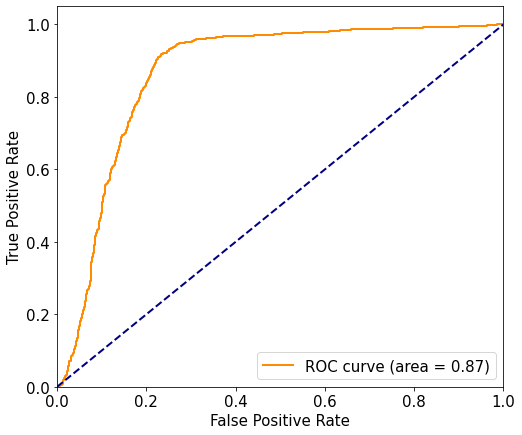

In [17]:
y_prediction = federated_government._server.evaluate_collaborative_model(
    test_data=test_data, test_label=test_labels)
plot_roc(test_labels, y_prediction)

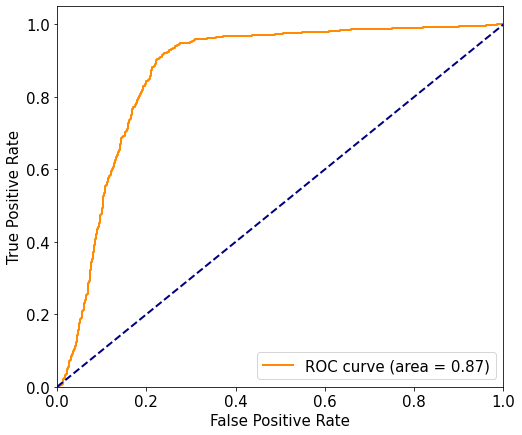

In [18]:
# Linear model Benchmark on centralized data using sk-learn:
#clf_linear = MLPClassifier(hidden_layer_sizes=(1,), max_iter=10000, shuffle=False, random_state=321).fit(x_train, y_train)

centralized_train_data = np.concatenate(train_data, axis=1)
centralized_test_data = np.concatenate(test_data, axis=1)

clf_linear = LogisticRegression(random_state=123).fit(centralized_train_data, train_labels)

y_prediction = clf_linear.predict_proba(centralized_test_data)[:, 1]
plot_roc(test_labels, y_prediction)

**Non-linear model:**

We now add a hidden layer in the clients' neural network model, resulting in a *non-linear* model (parameter `layer_dims=[3]`): 

In [19]:
#from shfl.model.vertical_deep_learning_model import VerticalNeuralNetClient

n_hidden_neurons = 3

model0 = nn.Sequential(
    nn.Linear(train_data[0].shape[1], n_hidden_neurons, bias=True),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, n_embeddings, bias=True)
)

model1 = nn.Sequential(
    nn.Linear(train_data[1].shape[1], n_hidden_neurons, bias=True),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, n_embeddings, bias=True)
)

optimizer0 = torch.optim.SGD(params=model0.parameters(), lr=0.001)
optimizer1 = torch.optim.SGD(params=model1.parameters(), lr=0.001)

batch_size = 32
model_nodes = [VerticalNeuralNetClient(model=model0, loss=None, optimizer=optimizer0, batch_size=batch_size),
               VerticalNeuralNetClient(model=model1, loss=None, optimizer=optimizer1, batch_size=batch_size)]

In [20]:
from shfl.federated_government.vertical_federated_deep_learning import FederatedGovernmentVertical


# Create federated government and run training:
federated_government = FederatedGovernmentVertical(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [21]:
federated_government.run_rounds(n=100001, 
                                test_data=test_data, 
                                test_label=test_labels, 
                                print_freq=1000)

Round 0
Collaborative model train loss: 0.7811171
Distributed model test AUC: 0.4144755204972168


Round 1000
Collaborative model train loss: 0.7491457
Distributed model test AUC: 0.4556259566819736


Round 2000
Collaborative model train loss: 0.6781591
Distributed model test AUC: 0.4846721991996316


Round 3000
Collaborative model train loss: 0.7119704
Distributed model test AUC: 0.5106786153022893


Round 4000
Collaborative model train loss: 0.7100583
Distributed model test AUC: 0.5370852600308271


Round 5000
Collaborative model train loss: 0.66095984
Distributed model test AUC: 0.5650890414246628


Round 6000
Collaborative model train loss: 0.6940332
Distributed model test AUC: 0.5971113315590828


Round 7000
Collaborative model train loss: 0.68327415
Distributed model test AUC: 0.6313834354683008


Round 8000
Collaborative model train loss: 0.6319237
Distributed model test AUC: 0.6672506760108162


Round 9000
Collaborative model train loss: 0.66568303
Distributed model test AUC: 0

In [22]:
print(federated_government._server._model)
print(federated_government._server._model.get_model_params())
print(federated_government._federated_data[0]._model.get_model_params())

[array([[1.5138656, 1.9820437]], dtype=float32), array([-0.25161472], dtype=float32)]
[array([[ 0.21062748,  0.15695095,  0.2702444 , -0.27530873, -0.03636552,
        -0.03191023, -0.14163738,  0.08601309, -0.28291404, -0.13037504,
         0.04215708],
       [ 0.10358739,  0.07742169,  0.03857182,  0.28238025,  0.17191468,
         0.13071992, -0.2944963 ,  0.06268974,  0.11429999, -0.02059554,
         0.11019966],
       [ 0.23146005,  0.0040451 ,  0.04486027, -0.00892835,  0.05601083,
        -0.06857363,  0.10147866,  0.13239641, -0.02822221, -0.12269864,
         0.09381031]], dtype=float32), array([-0.02383575,  0.06259727, -0.02370601], dtype=float32), array([[ 0.34081632, -0.23651646, -0.04260076],
       [-0.2387113 ,  0.1205874 , -0.1719974 ]], dtype=float32), array([-0.76004297, -1.0415198 ], dtype=float32)]


As before, we can compare the performance to the analogous centralized model using one hidden layer: 

Distributed model test AUC: 0.9258368133890142


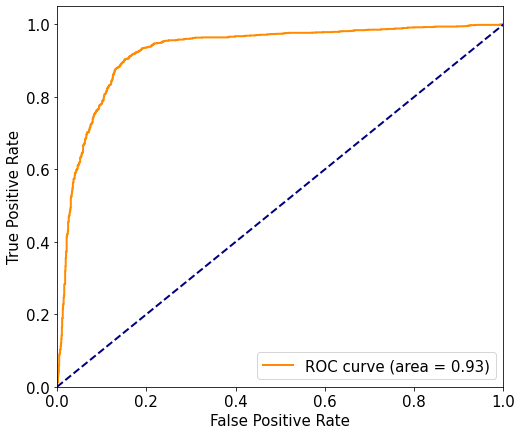

In [23]:
y_prediction = federated_government._server.evaluate_collaborative_model(
    test_data=test_data, test_label=test_labels)
plot_roc(test_labels, y_prediction)

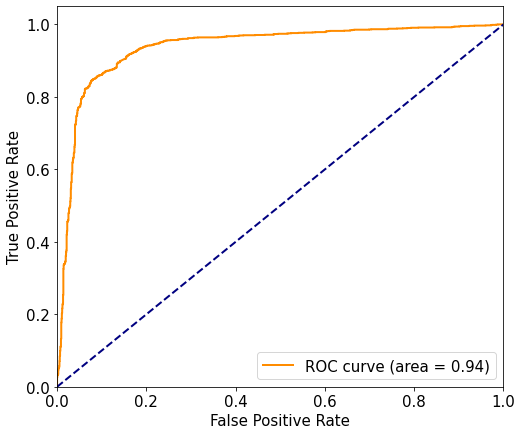

In [24]:
# Non-linear benchmark
clf_non_linear = MLPClassifier(hidden_layer_sizes=(3,), max_iter=10000, 
                               shuffle=False, random_state=3221)
clf_non_linear.fit(centralized_train_data, train_labels)

y_prediction = clf_non_linear.predict_proba(centralized_test_data)[:, 1]
plot_roc(test_labels, y_prediction)

In [25]:
server_node._model.get_model_params()

[array([[1.5138656, 1.9820437]], dtype=float32),
 array([-0.25161472], dtype=float32)]